In [1]:
from hipa_clip import get_hipa_clip_tokenizer, get_hipa_clip
from torch import nn
import torch
import numpy as np


class NewModel(nn.Module):
    def __init__(self, output_layers, *args):
        super().__init__(*args)
        self.output_layers = output_layers
        #print(self.output_layers)
        self.selected_out = OrderedDict()
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)
        self.fhooks = []

        for i,l in enumerate(list(self.pretrained._modules.keys())):
            if i in self.output_layers:
                self.fhooks.append(getattr(self.pretrained,l).register_forward_hook(self.forward_hook(l)))
    
    def forward_hook(self,layer_name):
        def hook(module, input, output):
            self.selected_out[layer_name] = output
        return hook

    def forward(self, x):
        out = self.pretrained(x)
        return out, self.selected_out


def interpret(image, texts, model, device, start_layer=-1, start_layer_text=-1):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    # logits_per_image, logits_per_text = model(images, texts) # logits_per_text, no use,calculate the similarity between text and images
    feature_per_image = model.visual(images)
    feature_per_text = model.text(texts)
    logits_per_image = feature_per_image @ feature_per_text.t()
    logits_per_text = logits_per_image.t()
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.trunk.blocks.named_children()).values())

    if start_layer == -1:
      # calculate index of last layer
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn.attn_drop.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn.attn_drop.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach() # one_hot blk.attn_probs 
        cam = blk.attn_probs.detach() # [12, 50, 50]
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:] #[1, 49],cls token with other patch tokens

    text_attn_blocks = list(dict(model.text.resblocks.named_children()).values())

    if start_layer_text == -1:
      # calculate index of last layer
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach() # [8, 77, 77]
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])# [8, 77, 77]
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])# [1, 8, 77, 77]
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text # [1, 77, 77], text_relevance[0, 6, :]  not zero

    return text_relevance, image_relevance

In [ ]:
input_img = "/hpc2hdd/JH_DATA/share/hlong883/hlong883_med_big_data_hlong/dataset_main/Qulit-1M/quilt_1m/BmF-kN6xvfk_image_fca92f68-1d55-4b01-b05d-f49b4aaeeeb0.jpg"
input_text = "Pleomorphic cells with a fibromyxoid stroma may require special stains for diagnosis. The presence of an epithelioid area and spindle areas with atypical cells and a mitotic figure suggests malignancy."
input_text_list = input_text.split(" ")


In [48]:
tokenizer = get_hipa_clip_tokenizer()
model, transform = get_hipa_clip(checkpoint="./hipa_clip_ep15.pt", remove_text=False, remove_visual=False)

In [8]:
from torchvision.models.feature_extraction import get_graph_node_names
from torch.nn import Dropout
# from timm.models.layers import PatchEmbed
nodes, _ = get_graph_node_names(model, tracer_kwargs={'leaf_modules': [Dropout]})
print(nodes)

TraceError: symbolically traced variables cannot be used as inputs to control flow

In [49]:
activation = {}
def get_activation(name, i):
    def hook(model, input, output):
        if name not in activation:
            activation[name] = [None for _ in range(24)]
        activation[name][i] = output.detach()
    return hook

for i, blk in enumerate(model.visual.trunk.blocks):
    blk.attn.register_forward_hook(get_activation('attn_drop', i))

# model.visual.trunk.blocks[23].attn.register_forward_hook(get_activation('attn_drop'))
# model.visual.trunk.blocks[23].norm1.register_forward_hook(get_activation('norm1'))

In [53]:
model=model.to('cuda')

In [10]:
input_img = "/hpc2hdd/JH_DATA/share/hlong883/hlong883_med_big_data_hlong/dataset_main/Qulit-1M/quilt_1m/BmF-kN6xvfk_image_fca92f68-1d55-4b01-b05d-f49b4aaeeeb0.jpg"
input_text = "Pleomorphic cells with a fibromyxoid stroma may require special stains for diagnosis. The presence of an epithelioid area and spindle areas with atypical cells and a mitotic figure suggests malignancy."

In [108]:
from PIL import Image
im = Image.open(input_img).convert("RGB")
im = transform(im).unsqueeze(0).to('cuda')
text = tokenizer([input_text]).to('cuda')

In [111]:
img_emb = model.visual(im)
# print(activation['attn_drop'])
# print(activation['norm1'])
# activation['attn_drop'].shape, activation['norm1'].shape
activation

{'attn_drop': [tensor([[[ 0.0849, -0.5285, -0.0360,  ...,  0.1078,  2.0352, -5.7571],
           [ 0.0831, -0.5284, -0.0337,  ...,  0.1070,  2.0271, -5.7461],
           [ 0.0850, -0.5285, -0.0361,  ...,  0.1078,  2.0355, -5.7575],
           ...,
           [ 0.0836, -0.5285, -0.0343,  ...,  0.1072,  2.0291, -5.7488],
           [ 0.0831, -0.5284, -0.0337,  ...,  0.1070,  2.0270, -5.7461],
           [ 0.0834, -0.5284, -0.0341,  ...,  0.1071,  2.0284, -5.7479]]],
         device='cuda:0'),
  tensor([[[ 0.3573,  1.0728, -0.2461,  ...,  1.1792, -0.8536,  0.3421],
           [ 0.2747,  1.6199, -0.1243,  ...,  1.6235, -1.6771,  1.4393],
           [ 0.2796,  1.6894, -0.1693,  ...,  1.6328, -1.5936,  1.6011],
           ...,
           [ 0.2110,  1.5466, -0.1689,  ...,  1.6949, -1.7710,  1.1139],
           [ 0.2565,  1.5416, -0.1312,  ...,  1.6279, -1.7295,  1.1727],
           [ 0.2558,  1.5929, -0.1398,  ...,  1.6316, -1.6638,  1.3891]]],
         device='cuda:0'),
  tensor([[[-0.4152, 

In [112]:
tensors = activation['attn_drop'].detach().cpu()
attn_map = tensors[:, 1:, :].reshape(tensors.size(0), 14, 14, tensors.size(2))
attn_map = attn_map.transpose(2, 3).transpose(1, 2)
# attn_map.shape
# average the attn map across all channnels
attn_map = attn_map.sum(1).numpy()
# attn_map = attn_map - attn_map.min()
# attn_map = attn_map / attn_map.max()
attn_map.shape

AttributeError: 'list' object has no attribute 'detach'

In [113]:
attn_map = None
for i, ts in enumerate(activation['attn_drop']):
    # if i <= 10 or i>=20: continue
    ts2 = ts.detach().cpu()
    ts2 = ts2[:, 1:, :].reshape(ts2.size(0), 14, 14, ts2.size(2))
    ts2 = ts2.transpose(2, 3).transpose(1, 2)
    ts2 = ts2.squeeze(0).numpy()
    if attn_map is None:
        attn_map = ts2
    else:
        attn_map = np.concatenate((attn_map, ts2), axis=0)
attn_map = attn_map.sum(0)
attn_map.shape

(14, 14)

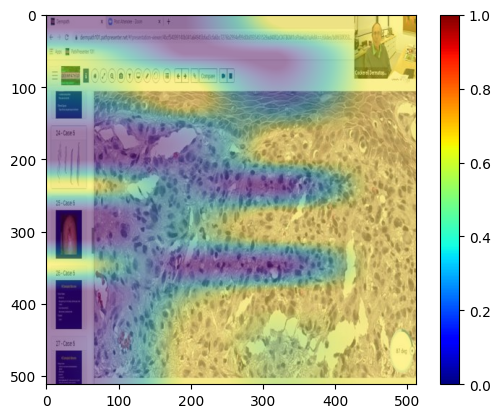

In [114]:
# show the attn map on the image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

attn_map = np.uint8(255 * attn_map)
attn_map = np.uint8(255 * cm.jet(attn_map))
attn_map = Image.fromarray(attn_map[0]).resize((512, 512))
im1 = Image.open(input_img).convert("RGB")
plt.imshow(im1)
plt.imshow(attn_map, alpha=0.5)
# show the jet colormap on the right
plt.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=plt.gca())
plt.show()

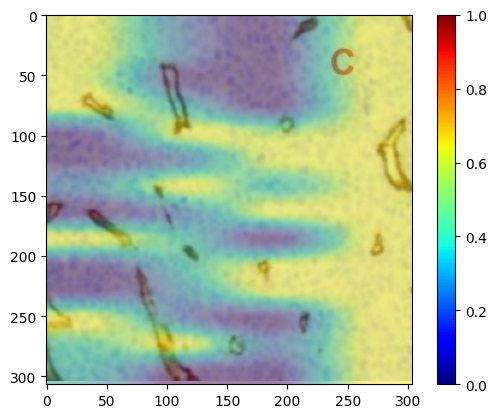

In [107]:
img2_path = "/hpc2hdd/JH_DATA/share/hlong883/hlong883_med_big_data_hlong/dataset_main/PathCap/images/29633732_ACTA-89-38-g001_1.jpg"
cap2 = "BMB (H&E) showing marked hypercellularity (insert at left upper corner) with marked granulocytic hyperplasia (50x)."
im = Image.open(img2_path).convert("RGB")
im = transform(im).unsqueeze(0).to('cuda')
img_emb = model.visual(im)
attn_map = None
for i, ts in enumerate(activation['attn_drop']):
    # if i >= 20: continue
    ts2 = ts.detach().cpu()
    ts2 = ts2[:, 1:, :].reshape(ts2.size(0), 14, 14, ts2.size(2))
    ts2 = ts2.transpose(2, 3).transpose(1, 2)
    ts2 = ts2.squeeze(0).numpy()
    if attn_map is None:
        attn_map = ts2
    else:
        attn_map = np.concatenate((attn_map, ts2), axis=0)
attn_map = attn_map.sum(0)
attn_map = np.uint8(255 * attn_map)
attn_map = np.uint8(255 * cm.jet(attn_map))
im1 = Image.open(img2_path).convert("RGB")
attn_map = Image.fromarray(attn_map[0]).resize((im1.height, im1.width))
plt.imshow(im1)
plt.imshow(attn_map, alpha=0.5)
# show the jet colormap on the right
plt.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=plt.gca())
plt.show()

In [22]:
text_relevance, image_relevance = interpret(im, text, model, 'cuda', start_layer=-1, start_layer_text=-1)

AttributeError: 'LayerNorm' object has no attribute 'shape'